<a href="https://colab.research.google.com/github/manushi0304/Diabetic_Retinopathy/blob/main/imageextractionDenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Upload one fundus image (or multiple):


Saving 1.jpg to 1.jpg
Loading model: /content/drive/MyDrive/DiabeticProject/saved_models/DenseNet121_single_split.keras
Loaded.
Probing backbone: densenet121  (layers: 428)
Input scaling: done in storyboard (/255)


/tmp/ipython-input-3516678455.py:96: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(arr, mode="L").resize(target_hw[::-1], resample=Image.BICUBIC)


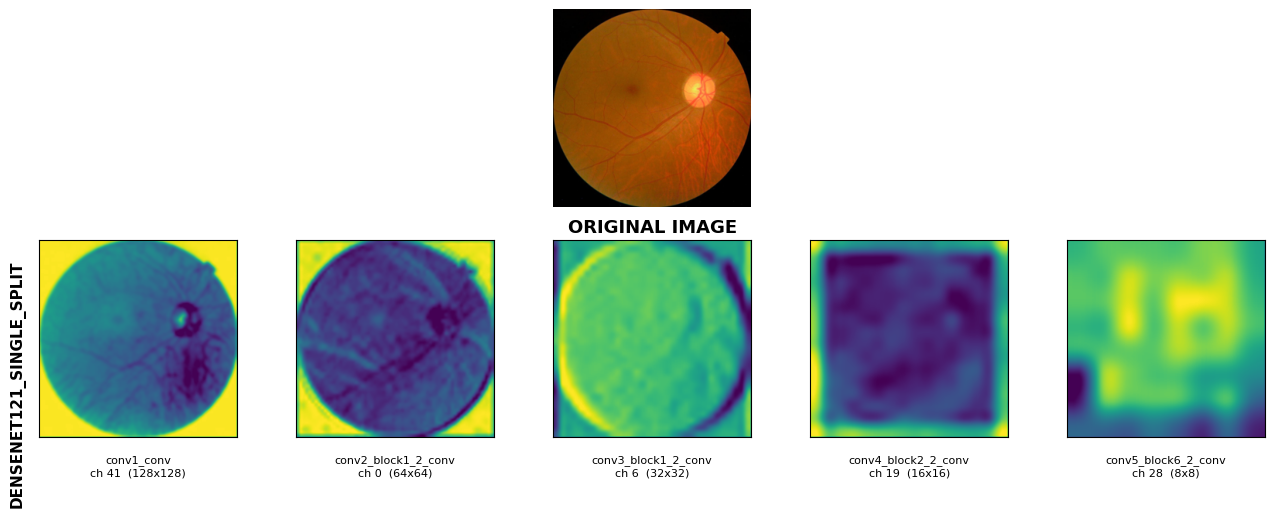

In [ ]:
# ==================== DenseNet Feature-Map Storyboard (Stage-aware, Conv-only) ====================
# Shows one informative conv/depthwise-conv map per stage (high→low resolution), bird-style.
# Auto-detects front-end Rescaling/Normalization to avoid double /255 scaling.

# ---- Mount Google Drive (Colab) ----
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image as kimage
from tensorflow.keras.layers import InputLayer

# ---------------- CONFIG ----------------
# (Change this to your exact DenseNet file name if different)
MODEL_PATH = "/content/drive/MyDrive/DiabeticProject/saved_models/DenseNet121_single_split.keras"

K_LAYERS   = 7           # number of tiles (6–10 looks great)
MIN_HW     = 4           # drop very small maps; 4 includes 7x7/8x8
CMAP       = "viridis"
UPSZ       = (192, 192)  # upsample each feature tile for clarity
USE_RETINA_PREPROC = False  # True = circle crop + CLAHE (visual clarity), False = dataset-style (resize only)
TITLE      = os.path.splitext(os.path.basename(MODEL_PATH))[0].upper()
# ---------------------------------------

# ---------- utilities ----------
def infer_input_size_from(model_like, fallback=(256,256)):
    s = model_like.input_shape
    if isinstance(s, list): s = s[0]
    try:
        _, H, W, _ = s
        if H and W: return (W, H)
    except Exception: pass
    return fallback

def backbone_has_rescaling(backbone):
    """Detect front-end Rescaling/Normalization so we avoid external /255."""
    from tensorflow.keras.layers import Rescaling, Normalization
    for lyr in backbone.layers[:8]:
        try:
            if isinstance(lyr, (Rescaling, Normalization)):
                return True
        except Exception:
            pass
        name = lyr.name.lower()
        if "rescaling" in name or "normalization" in name:
            return True
    return False

def preprocess_pil(pil_img, target_size, expects_rescaled, retina=False):
    """
    - retina=False: dataset-style (resize). If expects_rescaled==False, divide by 255 here.
    - retina=True : circle crop + CLAHE + resize. If expects_rescaled==False, divide by 255 here.
    If expects_rescaled==True, DO NOT divide (model handles scaling inside).
    """
    if not retina:
        img = pil_img.convert("RGB").resize(target_size, Image.BICUBIC)
        arr = np.array(img).astype("float32")
        if not expects_rescaled:
            arr = arr / 255.0
        return np.expand_dims(arr, 0), img

    # retina-friendly branch
    import cv2
    img = np.array(pil_img.convert("RGB"))
    h, w, _ = img.shape
    cy, cx = h//2, w//2
    r = int(0.48*min(h, w))
    Y, X = np.ogrid[:h, :w]
    mask = (X-cx)**2 + (Y-cy)**2 <= r*r
    bg = img.mean(axis=(0,1), keepdims=True).astype(np.uint8)
    img = np.where(mask[...,None], img, bg)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    hsv[:,:,2] = clahe.apply(hsv[:,:,2])
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    pil_out = Image.fromarray(img).resize(target_size, Image.BICUBIC)
    arr = np.array(pil_out).astype("float32")
    if not expects_rescaled:
        arr = arr / 255.0
    return np.expand_dims(arr, 0), pil_out

def percentile_normalize(x, lo=1, hi=99):
    p1, p2 = np.percentile(x, [lo, hi])
    x = np.clip(x, p1, p2)
    if p2 > p1: x = (x - p1) / (p2 - p1)
    else:       x = np.zeros_like(x)
    return x.astype("float32")

def upsample_gray(arr_hw, target_hw):
    arr = (arr_hw * 255.0).astype(np.uint8)
    pil = Image.fromarray(arr, mode="L").resize(target_hw[::-1], resample=Image.BICUBIC)
    return np.asarray(pil).astype("float32") / 255.0

def gaussian_blur(arr, sigma=0.55):
    a = tf.convert_to_tensor(arr[None, ..., None], dtype=tf.float32)
    k = int(2*round(3*sigma)+1)
    x = tf.range(-k//2+1, k//2+1, dtype=tf.float32)
    g = tf.exp(-0.5*(x/sigma)**2); g = g/tf.reduce_sum(g)
    gx = g[:,None,None,None]; gy = g[None,:,None,None]
    a = tf.nn.depthwise_conv2d(a, gx, [1,1,1,1], "SAME")
    a = tf.nn.depthwise_conv2d(a, gy, [1,1,1,1], "SAME")
    return tf.squeeze(a).numpy()

def find_backbone(top_model):
    """Pick nested model with 4-D input and most layers; else return top_model."""
    nested = [l for l in top_model.layers if isinstance(l, tf.keras.Model)]
    if not nested: return top_model
    def score(m):
        try:
            s = m.input_shape
            if isinstance(s, list): s = s[0]
            is4d = (len(s) == 4)
        except Exception: is4d = False
        return (is4d, len(m.layers))
    nested.sort(key=score, reverse=True)
    cand = nested[0]
    return cand if score(cand)[0] else top_model

def flatten_rank4_layers(a_model):
    """Return [(name, tensor)] for all rank-4 tensors in a_model (skip Input)."""
    outs = []
    for lyr in a_model.layers:
        if isinstance(lyr, InputLayer):
            continue
        try:
            t = lyr.output
        except Exception:
            continue
        ts = t if isinstance(t, (list,tuple)) else [t]
        for tt in ts:
            shp = getattr(tt, "shape", None)
            if shp is not None and len(shp) == 4:
                outs.append((lyr.name, tt))
    return outs

# Keep only conv layers (incl. depthwise/separable convs). Drop BN/pool/padding/concat/activations.
def is_conv_layer_keep(name, layer_obj=None):
    n = name.lower()
    # DenseNet uses lots of BN/Relu/Concat; we still skip those like before
    if any(k in n for k in ["bn","batchnorm","pool","padding","zero_padding","concat","input","relu","act","swish"]):
        return False
    if "conv" not in n:   # keep conv2d, depthwise_conv2d, separableconv2d, etc.
        return False
    ks = getattr(layer_obj, "kernel_size", None)
    if ks is not None:
        return (ks[0] * ks[1]) >= 9  # prefer >=3x3
    return True

def best_channel_by_variance(fmap_hwcn):
    H,W,C = fmap_hwcn.shape
    var = fmap_hwcn.reshape(-1, C).var(axis=0)
    ci = int(np.argmax(var))
    ch = fmap_hwcn[..., ci].astype("float32")
    ch = percentile_normalize(ch, 1, 99)
    ch = upsample_gray(ch, UPSZ)
    ch = gaussian_blur(ch, sigma=0.55)
    return ch, ci

# ---------- main storyboard ----------
def storyboard_stage_aware(model_path, pil_img, k_layers=7, min_hw=4, cmap="viridis", title_left="MODEL"):
    print(f"Loading model: {model_path}")
    top_model = load_model(model_path, compile=False)
    print("Loaded.")
    backbone = find_backbone(top_model)
    print(f"Probing backbone: {backbone.name}  (layers: {len(backbone.layers)})")

    # detect scaling inside model
    expects_rescaled = backbone_has_rescaling(backbone)
    print("Input scaling:", "handled by model (internal Rescaling/Normalization detected)"
          if expects_rescaled else "done in storyboard (/255)")

    # Use backbone input size to probe internals
    in_wh = infer_input_size_from(backbone, fallback=infer_input_size_from(top_model))
    batch, disp_img = preprocess_pil(
        pil_img, in_wh, expects_rescaled=expects_rescaled, retina=USE_RETINA_PREPROC
    )

    # collect rank-4 conv/depthwise-conv layers only
    rank4 = flatten_rank4_layers(backbone)
    rank4_conv = []
    for (n, t) in rank4:
        try:
            layer_obj = backbone.get_layer(n)
        except Exception:
            layer_obj = None
        if is_conv_layer_keep(n, layer_obj):
            rank4_conv.append((n, t, layer_obj))

    if not rank4_conv:
        raise RuntimeError("No suitable conv layers found. Try relaxing the filter or MIN_HW.")

    # probe once to know sizes & quick variance per layer
    size_probe = Model(inputs=backbone.input, outputs=[t for _, t, _ in rank4_conv])
    outs = size_probe.predict(batch, verbose=0)
    outs = outs if isinstance(outs, (list,tuple)) else [outs]

    # group by spatial size → choose highest-variance conv per stage
    stages = {}  # (H,W) -> list[(name,tensor,var,is_big_kernel)]
    for (n, t, layer_obj), fm in zip(rank4_conv, outs):
        fm = fm[0] if fm.ndim == 4 else fm
        if fm.ndim != 3: continue
        H,W,C = fm.shape
        if H < min_hw or W < min_hw: continue
        var = fm.reshape(-1, C).var(axis=0).max()
        ks = getattr(layer_obj, "kernel_size", None)
        big_kernel = (ks is not None and ks[0]*ks[1] >= 9)
        stages.setdefault((H,W), []).append((n, t, var, big_kernel))

    if not stages:
        raise RuntimeError("All conv maps fell below MIN_HW; set MIN_HW=2–4.")

    # pick best big-kernel conv per stage; if none, fall back to best variance
    picked_per_stage = []
    for sz in sorted(stages.keys(), key=lambda s: s[0], reverse=True):  # high→low res
        items = stages[sz]
        bigs  = [x for x in items if x[3]]
        chosen = max(bigs, key=lambda x: x[2]) if bigs else max(items, key=lambda x: x[2])
        picked_per_stage.append(chosen[:2])  # (name, tensor)

    # thin or keep to exactly k_layers evenly spaced
    if len(picked_per_stage) > k_layers:
        idxs = np.linspace(0, len(picked_per_stage)-1, num=k_layers, dtype=int)
        picked = [picked_per_stage[i] for i in idxs]
    else:
        picked = picked_per_stage

    # probe again for just the picked layers
    probe = Model(inputs=backbone.input, outputs=[t for _, t in picked])
    outs2 = probe.predict(batch, verbose=0)
    outs2 = outs2 if isinstance(outs2, (list,tuple)) else [outs2]

    # build display tiles
    images, labels, ch_ids, sizes = [], [], [], []
    for (lname, _), fm in zip(picked, outs2):
        if hasattr(fm, "numpy"): fm = fm.numpy()
        if fm.ndim == 4: fm = fm[0]
        if fm.ndim != 3: continue
        H,W,C = fm.shape
        if H < min_hw or W < min_hw: continue
        ch, ci = best_channel_by_variance(fm)
        images.append(ch); labels.append(lname); ch_ids.append(ci); sizes.append((H,W))

    if not images:
        raise RuntimeError("Picked layers produced no displayable maps—lower MIN_HW or increase K_LAYERS.")

    # ---- render ----
    cols = len(images)
    plt.figure(figsize=(cols*2.6, 5.4))

    ax_top = plt.subplot(2, 1, 1)
    ax_top.imshow(disp_img); ax_top.set_axis_off()
    # === place label BELOW the image instead of above ===
    ax_top.text(0.5, -0.06, "ORIGINAL IMAGE", transform=ax_top.transAxes,
                ha='center', va='top', fontsize=13, fontweight='bold')

    for i, (img, lname, ci, (h,w)) in enumerate(zip(images, labels, ch_ids, sizes), start=1):
        ax = plt.subplot(2, cols, cols + i)
        ax.imshow(img, cmap=cmap, vmin=0, vmax=1)
        ax.set_xticks([]); ax.set_yticks([])
        # === place label BELOW each child image ===
        ax.text(0.5, -0.09, f"{lname}\nch {ci}  ({h}x{w})", transform=ax.transAxes,
                ha='center', va='top', fontsize=8)

    plt.gcf().text(0.006, 0.28, title_left, rotation=90, va='center', ha='left',
                   fontsize=11, weight='bold')
    plt.tight_layout()
    # a little extra bottom padding so the below-labels are fully visible
    plt.subplots_adjust(bottom=0.18)
    plt.show()

# ---------- upload & run ----------
from google.colab import files
print("Upload one fundus image (or multiple):")
up = files.upload()
if not up: raise SystemExit("No image uploaded.")

for name, data in up.items():
    path = f"/content/_uploads_{name}"
    with open(path, "wb") as f: f.write(data)
    pil = Image.open(path)
    storyboard_stage_aware(
        MODEL_PATH, pil,
        k_layers=K_LAYERS, min_hw=MIN_HW, cmap=CMAP, title_left=TITLE
    )
